##Data Initialization
We are working with two sets of data. 

A training set (X_train) with 50000 images, each of dimensions 32x32 pixels where each pixels are represented using 3 values (RGB values).

A testing set (X_test) with the same characteristics, but 10000 samples.

Labels for both training and testing set (y_train/y_test) that map each of the respective 50000 and 10000 samples to one of 10 classes.

In [ ]:
%pip install patool
import patoolib
import pandas as pd
import numpy as np
import requests
import os
from keras.datasets import cifar10
import cv2

from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


These 10 classes are identified in the cifar_classes array in the following code. 

This snippet of code's purpose is to give a visual representation of the data we are working with.

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


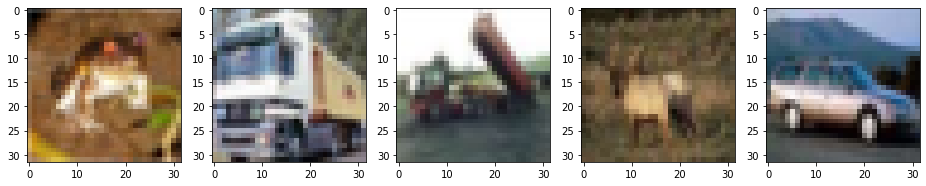

In [ ]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = X_train[i]
    axarr[i].imshow(img)
plt.show()

##Data preprocessing

Here, PCA (principal component analysis) and whitening techniques are used to preprocess our data.

The following steps are taken in order:
*   Mean-Centering 
*   Normalization (of RGB values in its scale with upper bound of 255
*   PCA 
*   Whitening







In [ ]:
# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3) (flatten the arrays)

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# zero-centering of pixel values using mean FROM THE TRAINING SET (IMPORTANT)

X_train -= np.mean(X_train, axis = 0)
X_test -= np.mean(X_train, axis = 0)

#Unnormalized set
X_train_unnormalized = X_train

# Normalization of RGB pixel values (to [0-1] range)

X_train /= 255
X_test /= 255


#get the training data covariance matrix

cov = np.dot(X_train.T, X_train) / X_train.shape[0]

#compute the SVD factorization of the data covariance matrix

U,S,V = np.linalg.svd(cov)

#Decorrelate the data 

X_train_rot = np.dot(X_train, U) 
X_test_rot = np.dot(X_test, U) 

#Xrot_reduced becomes [N x 100] (PCA DIMENSION REDUCTION)

#X_train_rot_reduced = np.dot(X_train_rot, U[:,:100])
#X_test_rot_reduced = np.dot(X_test_rot, U[:,:100]) 

##Data Whitening (On the PCA filtered data)

epsilon = 1e-5

#Divide by the eigenvalues (which are square roots of the singular values) P.S smoothing data by choosing a larger epsilon
Xwhite_train = X_train_rot / np.sqrt(S + epsilon)
Xwhite_test = X_test_rot / np.sqrt(S + epsilon)



##Function definition of different activation functions and their derivatives 




In [ ]:
#softmax function 
def softmax(x, derivative=False):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    probs = exps / np.sum(exps, axis=-1, keepdims=True)
    if derivative:
        return probs * (1 - probs)
    return probs

#DEFINING ACTIVATION FUNCTIONS AND THEIR DERIVATIVES

#logistic    
def logistic(x, derivative=False):
  y = 1/(1+np.exp(-x))
  if derivative:
      return y*(1-y)
  return y

#tanh
def tanh(x, derivative=False):
    y = np.tanh(x)
    if derivative:
      return 1 - y ** 2
    return y

#Leaky ReLU
def LeakyReLU(x, sigma=0.01, derivative=False):
    y = np.maximum(x, 0) + sigma * np.minimum(x,0)
    if derivative:
        return y/x + 2
    return y

def ReLU(x, derivative=False):
  if derivative:
    return (x>0).astype(int)
  return np.maximum(x,0)

###Define Plotting function for accuracy plots

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy1, accuracy2, xlabel = "X-axis name", title = "Accuracy of MLP"):
    epochs = range(1, len(accuracy1) + 1)
    plt.plot(epochs, accuracy1, 'b', label='Training accuracy')
    plt.plot(epochs, accuracy2, 'r', label='Testing accuracy')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


##Multilayer Perception (MLP) class initialization

In [ ]:
import numpy as np
import math
from sklearn.metrics import accuracy_score

class MLP:

  
    def __init__(self, X, y, activation_function = [ReLU, ReLU], number_hidden_layers = 2, layers = [64,64], alpha=0.1, epochs = 20, batch_size = None, L1_reg=0, L2_reg=0):
        
        self.X = X
        self.y = y
          
        self.layers = layers
        self.alpha = alpha
        self.weights = []
        self.batch_size = batch_size
        self.epochs = epochs
        self.L1_reg = L1_reg
        self.L2_reg = L2_reg
        
        #Add softmax as last layer activation function (Classification problem for images)
        self.activation_function = activation_function
        self.activation_function.append(softmax)

        #Input shape
        N,D = X.shape

        self.N = N
        self.D = D
        #Output shape
        self.yN,self.yD = y.shape

        #Add input layer to layers of MLP
        self.layers.insert(0,D)

        #Add output layer to layers of MLP (One output as this is a class)
        self.layers.append(self.yD)

      
        #For all connection between layers (except last one)
        for i in range(0, len(layers) - 2):

            #Initialize weights from a standard normal distribution. Adding 1 to the layers as a bias term (connects each current layer
            #to all of the next layer units))
            w = np.random.randn(layers[i], layers[i+1])

            #Scale w to normalize the variance of each neuron’s output by dividing by the square root of the number of nodes
            #weights is a list of lists. Each inner list is the weights connecting a layer to the next layer (pre-activation weights)
            
            #self.weights.append(w / np.sqrt(layers[i]))
            self.weights.append(w * 0.01)

        
        #Weight initialization for the final two layers because the output layer does not need a bias term
        #Once again, scale w to normalize the variance of each neuron’s output by dividing by the square root of the number of nodes


        w = np.random.randn(layers[-2], layers[-1])
        #self.weights.append(w / np.sqrt(layers[-2]))
        self.weights.append(w * 0.01)


        #Weight is a list of weights. Each element is a 2d-weight matrix. Each element of that matrix are the weights that connect
        #A node to every node of the next layer


    #Forward pass function (predict) takes input and returns an array of the output of each layer of the MLP

    def predict(self, X):
      # Add bias to input (column of 1) if add_Bias is True
      
          
      # Compute output of each layer
      output = X

      #Array of output values for each layers (array of pre-activation)
      z = [X] 

      for i in range(len(self.weights)):
          # Compute pre-activation of the next layer. This returns an array where each element is the z of the next layer (pre-activation)
          pre_activation = np.dot(output, self.weights[i])
          # Apply activation function to pre-activation. This acts on each element of the next layer (post-activation)
          output = self.activation_function[i](pre_activation)
          z.append(output)
      
      #Return array of each layer output
      return z


    #Backward_pass (fit) takes input and corresponding output. It computes the error of the predicted and actual output
    #It uses this error to backwards propogate and compute the gradient between output and each layer's weights
    #Finally, it updates the weights accordingly by gradient descent


    def fit(self, X, Y):
      # Compute the error of the output layer as the difference
      #between the forward pass and the actual label

      #Array of output for each layer (Forward pass)
      z = self.predict(X)

      #Array of predicted y for each of the classes based on the input
      yh = z[-1]

      #Difference between expected and actual output
      #yh is the softmax output for each classes based on the input. 
      #Y is an array of 0, with a 1 at the index of the correct class
      dy = yh - Y

      #D is an array of the derivatives for each layer (dz)
      #D = [dy * softmax(yh,derivative = True)] 
      D = [dy] 


      #For each layer starting from the output side of the MLP (ignoring last two layers as 
      #they have been taken care of already)
      for layer in range(len(z) - 2, 0, -1):

        #Dot product between current layer's derivative and current layer's weights
        delta = np.dot(D[-1],self.weights[layer].T)

        #Chain rule multiplies the derivative by the activation function's derivative (dw)
        delta *= self.activation_function[layer](z[layer],derivative = True)

        #Append derivative of the previous layer to D. Continue backpropagation in next loop
        D.append(delta)

      #Reverse delta array to get derivative in order of layers
      D = D[::-1]

      #Update weights phase

      #For each layer
      for layer in range(0,len(self.weights)):

        dw = np.dot(z[layer].T,D[layer])

        #breakpoint()
       
        # Add L1 regularization if specified
        if self.L1_reg != 0:
            dw = np.add(np.dot(self.L2_reg, np.abs(self.weights[layer])), dw)

        # Add L2 regularization if specified
        if self.L2_reg != 0:
            dw = np.add(np.dot(self.L2_reg, self.weights[layer]), dw)

        #Update the weight at the layer by going in the opposite direction of the gradient
        self.weights[layer] += -self.alpha * dw

      
    #Function evaluates the accuracy of the model on an input batch
    def evaluate_acc(self, X, y):

      N,D = X.shape
      correct = 0

      for instance in range(N):

        yh = np.argmax(self.predict(X[instance])[-1])

        y_true = np.argmax(y[instance])

        if yh == y_true:
          correct +=1

      accuracy = correct / N

      return accuracy

    #Training function for the MLP with respect to epochs
    def train(self, accuracy_history = False):
      #Number of batches based on instances per batch
      batch = self.N // self.batch_size

      #Index of each instance
      indices = np.arange(self.N)

      test_accuracy = []
      train_accuracy = []

      #For each epoch (iteration)
      for epoch in range(self.epochs):
        #shuffle the indices of the instances
        np.random.shuffle(indices)

        #For each batch
        for i in range(batch):

          #Get "batch_size" random index. This represents the index of 
          # "batch_size" randomized samples

          batch_indices = indices[i * self.batch_size:(i + 1) * self.batch_size]

          #Randomized samples and corresponding labels for the current batch
          X_batch = self.X[batch_indices]
          y_batch = self.y[batch_indices]
         
          #Update weights using current batch
          #self.fit(X_batch,y_batch)
          self.fit(X_batch,y_batch)


        if accuracy_history:
          
          #append current accuracy from training and testing set

          train_accuracy.append(self.evaluate_acc(Xwhite_train,y_train))
          test_accuracy.append(self.evaluate_acc(Xwhite_test,y_test))

        #print(self.weights[0], epoch)
          
          
      return train_accuracy, test_accuracy


###Test to see how our MLP model trains .
This is a sanity check to make sure it performs somewhat normally

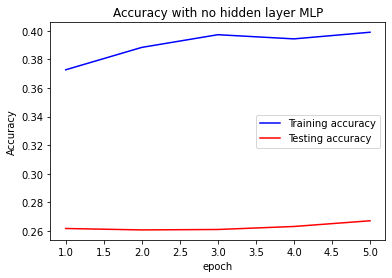

In [ ]:

MLP_test = MLP(Xwhite_train, y_train, activation_function = [], number_hidden_layers = 0, layers = [], alpha=1, epochs = 5, batch_size = 8, add_Bias = False)
train_accuracy_MLP_test, test_accuracy_MLP_test = MLP_test.train(accuracy_history = True)


plot_accuracy(train_accuracy_MLP_test, test_accuracy_MLP_test, "epoch", title = "Accuracy with no hidden layer MLP")


##Experiment 1
1. MLP with no hidden layers

2. MLP with a single hidden layer of 256 units and ReLU activation

3. MLP with two hidden layers, each of 256 units and ReLU activation

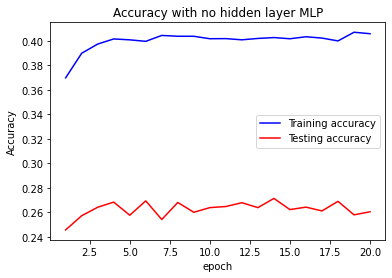

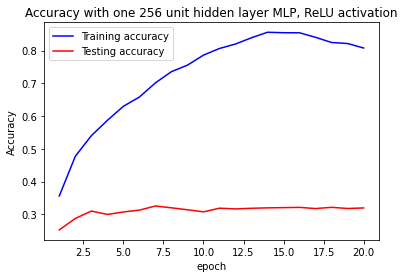

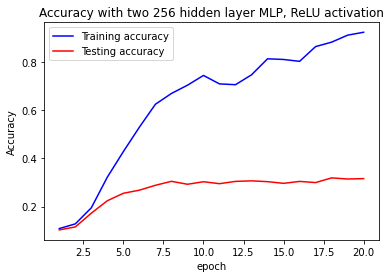

In [ ]:

#Instantiation of all three MLPs
MLP1 = MLP(Xwhite_train, y_train, activation_function = [], number_hidden_layers = 0, layers = [], alpha=1, epochs = 20, batch_size = 8)
train_accuracy_MLP1, test_accuracy_MLP1 = MLP1.train(accuracy_history = True)
plot_accuracy(train_accuracy_MLP1, test_accuracy_MLP1, "epoch", title = "Accuracy with no hidden layer MLP")


MLP2 = MLP(Xwhite_train, y_train, activation_function = [ReLU], number_hidden_layers = 1, layers = [256], alpha=0.01, epochs = 20, batch_size = 8)        
train_accuracy_MLP2, test_accuracy_MLP2 = MLP2.train(accuracy_history = True)
plot_accuracy(train_accuracy_MLP2, test_accuracy_MLP2, "epoch", title = "Accuracy with one 256 unit hidden layer MLP, ReLU activation")


MLP3 = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 20, batch_size = 8)        
train_accuracy_MLP3, test_accuracy_MLP3 = MLP3.train(accuracy_history = True)
plot_accuracy(train_accuracy_MLP3, test_accuracy_MLP3, "epoch", title = "Accuracy with two 256 hidden layer MLP, ReLU activation")





###Determining max accuracies and corresponding epoch for training and testing set for Experiment 1





In [ ]:
print("MLP1_max_train: ", max(train_accuracy_MLP1), "Epoch: ", np.argmax(train_accuracy_MLP1), "MLP1_max_test: ", max(test_accuracy_MLP1), "Epoch: ", np.argmax(test_accuracy_MLP1))
print("MLP2_max_train: ", max(train_accuracy_MLP2), "Epoch: ", np.argmax(train_accuracy_MLP2), "MLP2_max_test: ", max(test_accuracy_MLP2), "Epoch: ", np.argmax(test_accuracy_MLP2))
print("MLP3_max_train: ", max(train_accuracy_MLP3), "Epoch: ", np.argmax(train_accuracy_MLP3), "MLP3_max_test: ", max(test_accuracy_MLP3), "Epoch: ", np.argmax(test_accuracy_MLP3))

MLP1_max_train:  0.40694 Epoch:  18 MLP1_max_test:  0.2713 Epoch:  13
MLP2_max_train:  0.85614 Epoch:  13 MLP2_max_test:  0.3254 Epoch:  6
MLP3_max_train:  0.92328 Epoch:  19 MLP3_max_test:  0.3191 Epoch:  17


##Experiment 2
1. MLP with two hidden layers, each 256 units but tanh activations

2. MLP with two hidden layers, each 256 units but Leaky ReLU activations


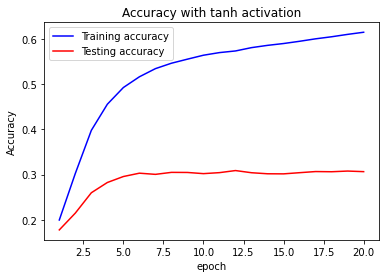

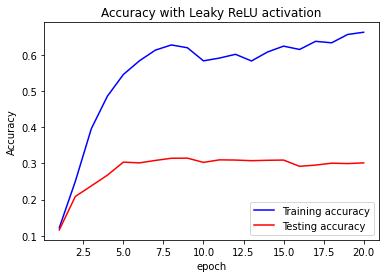

In [ ]:
#Instantiate the new MLPs


MLP3_1 = MLP(Xwhite_train, y_train, activation_function = [tanh,tanh], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 20, batch_size = 8)        
train_accuracy_MLP3_1, test_accuracy_MLP3_1 = MLP3_1.train(accuracy_history = True)

MLP3_2 = MLP(Xwhite_train, y_train, activation_function = [LeakyReLU, LeakyReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 20, batch_size = 8)        
train_accuracy_MLP3_2, test_accuracy_MLP3_2 = MLP3_2.train(accuracy_history = True)

#Plot each of the MLPs
plot_accuracy(train_accuracy_MLP3_1, test_accuracy_MLP3_1, "epoch", title = "Accuracy with tanh activation")
plot_accuracy(train_accuracy_MLP3_2, test_accuracy_MLP3_2, "epoch", title = "Accuracy with Leaky ReLU activation")


###Determining max accuracies and corresponding epoch for training and testing set for Experiment 2


In [ ]:
print("MLP3_1_max_train: ", max(train_accuracy_MLP3_1), "Epoch: ", np.argmax(train_accuracy_MLP3_1), "MLP3_1_max_test: ", max(test_accuracy_MLP3_1), "Epoch: ", np.argmax(test_accuracy_MLP3_1))
print("MLP3_2_max_train: ", max(train_accuracy_MLP3_2), "Epoch: ", np.argmax(train_accuracy_MLP3_2), "MLP3_2_max_test: ", max(test_accuracy_MLP3_2), "Epoch: ", np.argmax(test_accuracy_MLP3_2))


MLP3_1_max_train:  0.61488 Epoch:  19 MLP3_1_max_test:  0.3089 Epoch:  11
MLP3_2_max_train:  0.66294 Epoch:  19 MLP3_2_max_test:  0.3145 Epoch:  8


##Experiment 3

We tune L1 and L2 Reg hyperparameters first, and then we set those for further experiments:

1. MLP with two hidden layers (256 units), ReLU activations, L1 regularized

2. MLP with two hidden layers (256 units), ReLU activations, L2 regularized




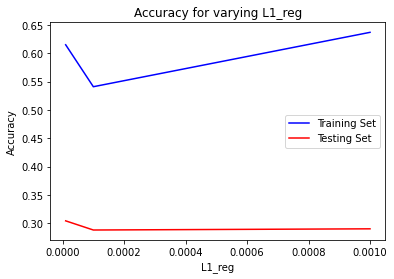

In [ ]:
Train_result = []
Test_result = []
Values = [1e-5,1e-4,0.001]

for L1_Reg in Values:

  MLP_L1_tune = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 7, batch_size = 8, L1_reg = L1_Reg)        

  train,test = MLP_L1_tune.train(True)

  Train_result.append(train[-1])
  Test_result.append(test[-1])


plt.plot(Values, Train_result, 'b', label='Training Set')
plt.plot(Values, Test_result, 'r', label='Testing Set')
plt.title("Accuracy for varying L1_reg")
plt.xlabel("L1_reg")
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
print("Max_L1_Reg_Train: ", Values[np.argmax(Train_result)])
print("Max_L1_Reg_Test: ", Values[np.argmax(Test_result)])


Max_L1_Reg_Train:  0.001
Max_L1_Reg_Test:  1e-05


L1_Reg accuracy peaks for a value of 0.001

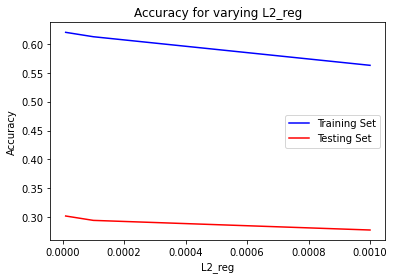

In [ ]:
Train_result_L2 = []
Test_result_L2 = []
Values_L2 = [1e-5,1e-4,0.001]

for L2_Reg in Values_L2:

  MLP_L2_tune = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 7, batch_size = 8, L2_reg = L2_Reg)        

  train,test = MLP_L2_tune.train(True)

  Train_result_L2.append(train[-1])
  Test_result_L2.append(test[-1])

plt.plot(Values_L2, Train_result_L2, 'b', label='Training Set')
plt.plot(Values_L2, Test_result_L2, 'r', label='Testing Set')
plt.title("Accuracy for varying L2_reg")
plt.xlabel("L2_reg")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Max_L2_Reg_Train: ", Values_L2[np.argmax(Train_result_L2)])
print("Max_L2_Reg_Test: ", Values_L2[np.argmax(Test_result_L2)])

Max_L2_Reg_Train:  1e-05
Max_L2_Reg_Test:  1e-05


L2_Reg accuracy peaks for a value of 1e-05

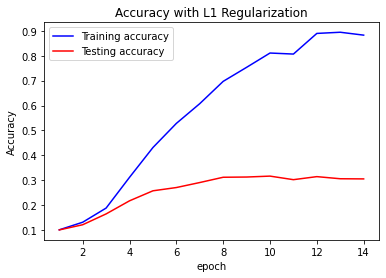

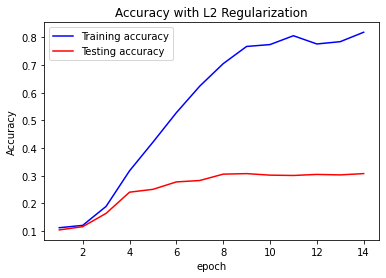

In [ ]:
#Instantiate the MLPs

MLP_L1 = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 14, batch_size = 8, L1_reg = 0.001)        
train_accuracy_MLP_L1, test_accuracy_MLP_L1 = MLP_L1.train(accuracy_history = True)


MLP_L2 = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 14, batch_size = 8, L2_reg=1e-05)        
train_accuracy_MLP_L2, test_accuracy_MLP_L2 = MLP_L2.train(accuracy_history = True)


#Plot each of the MLPs
plot_accuracy(train_accuracy_MLP_L1, test_accuracy_MLP_L1, "epoch", title = "Accuracy with L1 Regularization")
plot_accuracy(train_accuracy_MLP_L2, test_accuracy_MLP_L2, "epoch", title = "Accuracy with L2 Regularization")


In [ ]:
print("Max_L1_Train: ", max(train_accuracy_MLP_L1), "Max_L1_Test: ", max(test_accuracy_MLP_L1))
print("Max_L2_Train: ", max(train_accuracy_MLP_L2), "Max_L2_Test: ", max(test_accuracy_MLP_L2))

Max_L1_Train:  0.89442 Max_L1_Test:  0.3166
Max_L2_Train:  0.81876 Max_L2_Test:  0.3078


##Experiment 4
1. MLP with two hidden layers (256 units), ReLU activations, unnormalized images





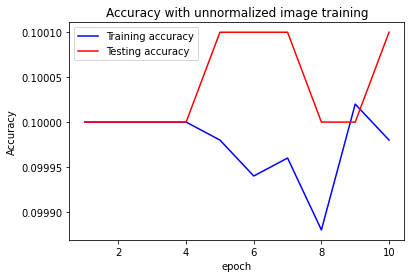

In [ ]:

#Unnormalized images
X_train_unnormalized = X_train * 255
X_test_unnormalized = X_test* 255

#Instantiate MLP
MLP_not_normalized = MLP(X_train_unnormalized, y_train, activation_function = [ReLU,ReLU], number_hidden_layers = 2, layers = [256,256], alpha=0.01, epochs = 10, batch_size = 8)        
train_accuracy_MLP_not_normalized, test_accuracy_not_normalized = MLP_not_normalized.train(accuracy_history = True)

#Plot accuracy
plot_accuracy(train_accuracy_MLP_not_normalized, test_accuracy_not_normalized, "epoch", title = "Accuracy with unnormalized image training")




In [ ]:
print("Max_unnormalized_Train: ", max(train_accuracy_MLP_not_normalized), "Max_unnormalized_Test: ", max(test_accuracy_not_normalized))


Max_unnormalized_Train:  0.10002 Max_unnormalized_Test:  0.1001


##Experiment Extra MLP
1. MLP with two hidden layers (256 units), ReLU activations, but three hidden layers. Each of them having respectively:



*   256,128,64 units, alpha = 0.001
*   256,128,64 units, alpha = 0.01
*   256,256,256 units, alpha = 0.1







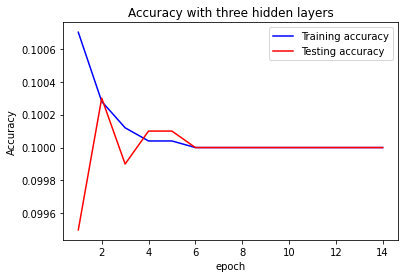

In [ ]:
#Instantiate the MLPs

MLP_Extra = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU,ReLU], number_hidden_layers = 3, layers = [256,128,64], alpha=0.001, epochs = 14, batch_size = 8, L2_reg = 1e-05)        
train_MLP_Extra, test_MLP_Extra = MLP_Extra.train(accuracy_history = True)

plot_accuracy(train_MLP_Extra, test_MLP_Extra, "epoch", title = "Accuracy with three hidden layers")


In [ ]:
print("Max_three_layers_Train: ", max(train_MLP_Extra), "Max_three_layers_Test: ", max(test_MLP_Extra))

Max_three_layers_Train:  0.1007 Max_three_layers_Test:  0.1003


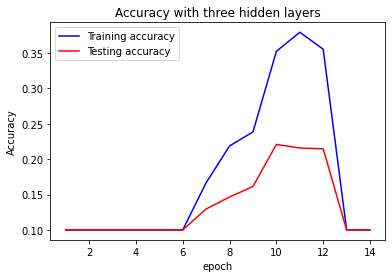

In [ ]:
#Instantiate the MLPs

MLP_Extra = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU,ReLU], number_hidden_layers = 3, layers = [256,128,64], alpha=0.01, epochs = 14, batch_size = 8, L2_reg = 1e-05)        
train_MLP_Extra, test_MLP_Extra = MLP_Extra.train(accuracy_history = True)

plot_accuracy(train_MLP_Extra, test_MLP_Extra, "epoch", title = "Accuracy with three hidden layers")

In [ ]:
print("Max_three_layers_Train: ", max(train_MLP_Extra), "Max_three_layers_Test: ", max(test_MLP_Extra))

Max_three_layers_Train:  0.37938 Max_three_layers_Test:  0.2208


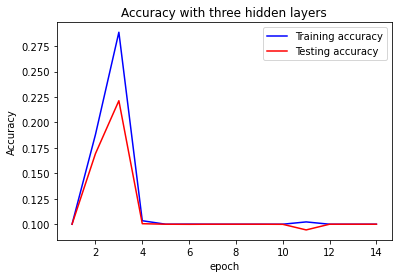

In [ ]:
#Instantiate the MLPs

MLP_Extra = MLP(Xwhite_train, y_train, activation_function = [ReLU,ReLU,ReLU], number_hidden_layers = 3, layers = [256,256,256], alpha=0.1, epochs = 14, batch_size = 8, L2_reg = 1e-05)        
train_MLP_Extra, test_MLP_Extra = MLP_Extra.train(accuracy_history = True)

plot_accuracy(train_MLP_Extra, test_MLP_Extra, "epoch", title = "Accuracy with three hidden layers")

In [ ]:
print("Max_three_layers_Train: ", max(train_MLP_Extra), "Max_three_layers_Test: ", max(test_MLP_Extra))

Max_three_layers_Train:  0.28856 Max_three_layers_Test:  0.2213
